# Tutorial 3b - Feature extraction from medical images

Original author: [Santeri Rytky](https://www.oulu.fi/fi/tutkijat/santeri-rytky) 

Deep learning models require a large amount of labeled data. In this tutorial, you will learn how to extract features from images that can be fed to conventional machine learning models. We compare the performance between small and large amounts of training data.

Topics covered:
- Medical image analysis techniques for machine learning 
- Creating a custom method for Feature extraction
- Working with limited data

The dataset used in this tutorial is called "Medical Mnist" and it is a collection of 64x64-sized images from six classes: Abdomen CT, Breast MRI, Chest X-ray, Chest CT, Hand X-ray and Head CT.
https://www.kaggle.com/andrewmvd/medical-mnist

In [2]:
# Extract the data folder (quietly). If you have already extracted, select N
# !unzip -q './MMnist.zip' -d './MMnist'

In [6]:
#!pip install scikit-image opencv-python-headless

<font size="5">Note that you need to unzip the "MMnist.zip" manually if you are using windows. The unzip command should work on linux.</font>

In [63]:
# Use ctrl to see details

import os  # Operating system functions
import glob
import numpy as np
import pandas as pd

# Visualize charts and images
import matplotlib.pyplot as plt


# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# Transformations
from skimage.transform import rotate
from skimage.util import random_noise

# Random variables
from random import randint, random, uniform

# Scikit-image (library for ML and image processing)
from skimage.feature import local_binary_pattern

# Image processing (OpenCV)
import cv2 

After the images are unpacked, we can look at the contents from the drive, or list the contents using Python.

In [10]:
# Extracted path
data_path = './MMnist/MMnist'
# List of folders/files
class_dir = os.listdir(data_path)
class_dir.sort()
print(class_dir)

['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


# 1. Data loading and preprocessing

Let's start by loading the images to one large array. At the same time, we can make a list including the corresponding classes for the images.

In [15]:
all_image_paths = glob.glob("./MMnist/MMnist/*/*.jpeg", recursive=True)
print(f'Total number of images: {len(all_image_paths)}')
print(f'First image path: {all_image_paths[:1]}')

Total number of images: 6000
First image path: ['./MMnist/MMnist/Hand/000289.jpeg']


In [16]:
label_map = {label:idx for idx, label in enumerate(class_dir)}
print(label_map)

{'AbdomenCT': 0, 'BreastMRI': 1, 'CXR': 2, 'ChestCT': 3, 'Hand': 4, 'HeadCT': 5}


In [19]:
# Empty arrays to accumulate all images and classes
all_images = []
all_classes = []

for image_path in all_image_paths:
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    all_images.append(image)
    
    # Extract class label from path
    class_label = image_path.split(os.sep)[-2]
    class_id = label_map[class_label]
    all_classes.append(class_id)

all_images = np.array(all_images)
all_classes = np.array(all_classes)

print(f'All images shape: {all_images.shape}')
print(f'All classes shape: {all_classes.shape}')

All images shape: (6000, 64, 64)
All classes shape: (6000,)


Next, we can split the data, similar to previous tutorials.

In [20]:
# Fix random seed
seed = 3

# Train and test split
X_train, X_test, Y_train, Y_test = train_test_split(all_images, all_classes, test_size=0.33, random_state=seed, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.33, random_state=seed, shuffle=True)
print(f'Training set consists of {len(X_train)} images, while the validation set includes {len(X_val)} images')
print(f'Test set includes {len(X_test)} images')

Training set consists of 2693 images, while the validation set includes 1327 images
Test set includes 1980 images


![Local Binary Patterns](https://scikit-image.org/docs/dev/_images/sphx_glr_plot_local_binary_pattern_001.png)

In this tutorial, we will create the features for the machine learning model using texture analysis method called "local binary pattern" (LBP). The LBP features consist of grayscale value comparison between the center pixel and its neighbours. The results of the comparison of each pixel are compiled into a single number.

Often rotation-invariant and uniform features are used, since they are most general and resistant to overfitting. In the above example (source: [Scikit-image](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html)), the rightmost pattern is not uniform (includes a gap). The "edge" and "corner" features can be rotated when using rotation-invariant mapping.

The next function allows plotting the lbp images (feature's location on the image) and histogram (the relative amount of each LBP feature)

In [21]:
def plot_lbp(input_image):
    n_points = 8
    radius = 3
    method = 'uniform'
    sample = 2
    lbp = local_binary_pattern(input_image, n_points, radius, method)
    lbp.shape

    fig, axs = plt.subplots(1, 3, figsize=(6, 2))
    plt.tight_layout()
    axs[0].imshow(input_image, cmap='gray')
    axs[0].set_title('Input image')
    axs[1].imshow(lbp, cmap='gray')
    axs[1].set_title('LBP image')
    axs[2].hist(lbp.ravel(), bins=10, range=None, fc='k', ec='k')
    axs[2].set_title('LBP histogram')
    plt.show()

Let's take a look at the LBP features for each class:

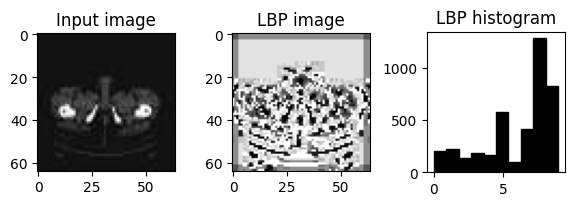

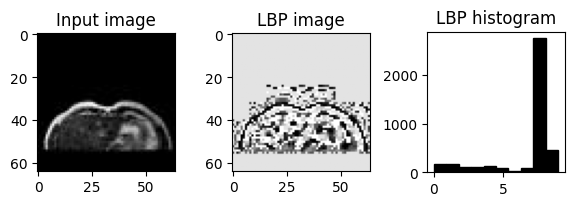

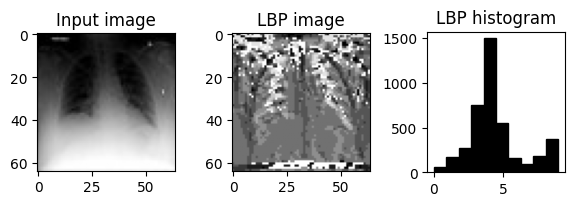

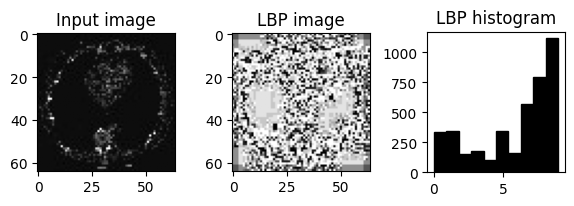

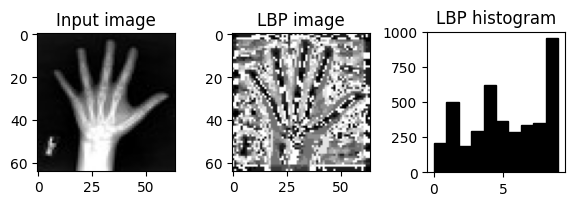

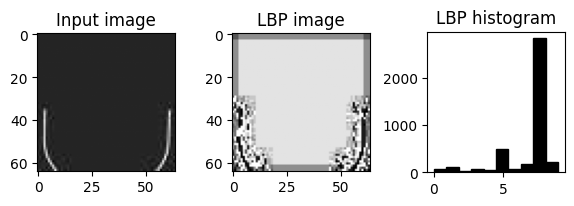

In [22]:
id = 0
plot_lbp(X_train[np.where(Y_train == 0)[0][id]])
plot_lbp(X_train[np.where(Y_train == 1)[0][id]])
plot_lbp(X_train[np.where(Y_train == 2)[0][id]])
plot_lbp(X_train[np.where(Y_train == 3)[0][id]])
plot_lbp(X_train[np.where(Y_train == 4)[0][id]])
plot_lbp(X_train[np.where(Y_train == 5)[0][id]])

As you can see from the histograms (frequency of the patterns, similar to the example figure), the images have varying amounts of the different features. You can try to change the `id` variable to get another set of images. 

# 2. Feature extraction and pipeline

To use the LBP technique as an **feature extractor** similar to previous tutorials, we should formulate it into a Python class. This allows to use the familiar methods `.fit()` and `.transform()`. The class allows us to plug the feature extractor into a scikit-learn **pipeline**, where LBP is combined with a classifier.

In contrast to a Python function, a **class** consists of functions, attributes or both. First, an instance of the class is created by defining the class variable in code, e.g. `extractor = FeatureExtractor()`. This calls the `__init__` function which sets the default settings and the input parameters for the class. Subsequently, the class variable can be called using the defined functions.

In [23]:
class FeatureExtractor():
    """
    Class to extract features using local binary pattern analysis.
    """
    def __init__(self, n_points=8, radius=3, method='uniform'):
        # Save parameters to the class instance
        self.n_points = n_points
        self.radius = radius
        self.method = method
        self.bins = 10

    # Just passes data through lbp pipeline, no parameters are learned
    def fit(self, X, y=None):
        self.fit_transform(X)
        return self
    # Returns lbp histograms of the given array
    def transform(self, X, y=None):
        return self._calculate_lbp(X)
    # Returns lbp histograms of the given array
    def fit_transform(self, X, y=None):
        return self._calculate_lbp(X)
    # Function to calculate lbp histograms
    def _calculate_lbp(self, image):
        # Array of images
        if len(image.shape) > 2:
            lbp = np.zeros((image.shape[0], self.bins))
            for id in range(image.shape[0]):
                lbp_image = local_binary_pattern(image[id, :, :], self.n_points, self.radius, self.method)
                lbp[id, :] = np.histogram(lbp_image, bins=self.bins)[0]
            return lbp
        # Single image
        else:
            lbp = local_binary_pattern(image, self.n_points, self.radius, self.method)
            return np.histogram(lbp, bins=10)[0]


Now we can run the pipeline including the feature extractor and classifier.

In [56]:
image_clf = Pipeline([('feature_extractor', FeatureExtractor(n_points=8, radius=3, method='uniform')),
                         ('classifier', SVC())])
print(f'Training set size: {X_train.shape[0]}')
print(f'Frequency of \n class 0: {np.sum(Y_train == 0)}\n',
f'class 1: {np.sum(Y_train == 1)}\n',
f'class 2: {np.sum(Y_train == 2)}\n',
f'class 3: {np.sum(Y_train == 3)}\n',
f'class 4: {np.sum(Y_train == 4)}\n',
f'class 5: {np.sum(Y_train == 5)}\n')

image_clf.fit(X_train, Y_train)
predictions = image_clf.predict(X_val)

# Predict on test for later
predictions_full = image_clf.predict(X_test)

# Validation results
print(f'Accuracy: {accuracy_score(predictions, Y_val):.3f}')
print(classification_report(Y_val, predictions, labels=[0, 1, 2, 3, 4, 5]))

# Create confusion matrix
conf = confusion_matrix(Y_val, predictions)
true_labels = ['True 0', 'True 1', 'True 2', 'True 3', 'True 4', 'True 5']
pred_labels = ['Pred 0', 'Pred 1', 'Pred 2', 'Pred 3', 'Pred 4', 'Pred 5']
with pd.option_context('display.max_columns', 10):
    print(pd.DataFrame(conf, index=true_labels,
                       columns=pred_labels))

Training set size: 2693
Frequency of 
 class 0: 447
 class 1: 430
 class 2: 458
 class 3: 468
 class 4: 454
 class 5: 436

Accuracy: 0.948
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       232
           1       0.99      1.00      0.99       220
           2       0.99      0.98      0.98       223
           3       0.93      0.95      0.94       218
           4       0.98      0.96      0.97       217
           5       0.93      0.88      0.91       217

    accuracy                           0.95      1327
   macro avg       0.95      0.95      0.95      1327
weighted avg       0.95      0.95      0.95      1327

        Pred 0  Pred 1  Pred 2  Pred 3  Pred 4  Pred 5
True 0     212       0       0       8       0      12
True 1       0     220       0       0       0       0
True 2       0       0     218       0       5       0
True 3      10       0       0     208       0       0
True 4       0       3       3       0     

Here, 0 = AbdomenCT, 1 = BreastMRI, 2 = CXR, 3 = ChestCT, 4 = Hand, 5 = HeadCT

We already got a pretty good accuracy of 0.896. However, the AbdomenCT class has slightly reduced scores. **Low recall** and **high precision** means that the positive predictions are very likely to be correct, but some of the AbdomenCT images are not detected. The opposite is true for ChestCT: All of the ChestCT images are detected (predicted positive), but the positive predictions contain incorrect cases. These are likely from AbdomenCT, since the image types are quite similar.

# 3. Limited dataset

Previously we used 2693 images to train the LBP + support vector machine classifier. Let's try out the performance on only 500 images.

In [57]:
image_clf = Pipeline([('feature_extractor', FeatureExtractor(n_points=8, radius=3, method='uniform')),
                         ('classifier', SVC())])
data_size = 100
print(f'Training set size: {data_size}')
print(f'Frequency of \n class 0: {np.sum(Y_train[:data_size] == 0)}\n',
f'class 1: {np.sum(Y_train[:data_size] == 1)}\n',
f'class 2: {np.sum(Y_train[:data_size] == 2)}\n',
f'class 3: {np.sum(Y_train[:data_size] == 3)}\n',
f'class 4: {np.sum(Y_train[:data_size] == 4)}\n',
f'class 5: {np.sum(Y_train[:data_size] == 5)}\n')

image_clf.fit(X_train[:data_size], Y_train[:data_size])
predictions = image_clf.predict(X_val)

# Predict on test for later
predictions_reduced = image_clf.predict(X_test)

# Validation results
print(f'Accuracy: {accuracy_score(predictions, Y_val):.3f}')
print(classification_report(Y_val, predictions, labels=[0, 1, 2, 3, 4, 5]))

# Create confusion matrix
conf = confusion_matrix(Y_val, predictions)
with pd.option_context('display.max_columns', 10):
    print(pd.DataFrame(conf, index=true_labels,
                       columns=pred_labels))

Training set size: 100
Frequency of 
 class 0: 12
 class 1: 20
 class 2: 10
 class 3: 18
 class 4: 25
 class 5: 15

Accuracy: 0.735
              precision    recall  f1-score   support

           0       0.38      0.01      0.03       232
           1       0.89      1.00      0.94       220
           2       0.99      0.77      0.87       223
           3       0.47      0.95      0.63       218
           4       0.80      0.93      0.86       217
           5       0.84      0.79      0.82       217

    accuracy                           0.73      1327
   macro avg       0.73      0.74      0.69      1327
weighted avg       0.73      0.73      0.68      1327

        Pred 0  Pred 1  Pred 2  Pred 3  Pred 4  Pred 5
True 0       3       0       0     211       0      18
True 1       0     220       0       0       0       0
True 2       0       1     171       0      50       1
True 3       0       0       0     208       0      10
True 4       1      10       1       1     201    

In this case, also the head CT images are mixed up with the other CT image types. The details of image classification results are shown in the **confusion matrix**. More training data is needed. But what if we would have only 500 images available for training?

# 4. Augmenting images

**Image augmentation** is used to create artificial images based on existing ones. This could often include rotation, flipping, cropping, padding, adding noise, blurring, adjusting brightness or contrast. The image class should not be altered, but some modifications could be done for more complicated prediction targets.

In [58]:
def random_augment(images, classes, n_images=1000):
    """
    Function to generate augmented images.
    """

    # Augmentation parameters
    angle_range = [-30, 30]
    variance_range = [0.001, 0.01]
    brightness_range = [-50, 50]
    contrast_range = [0.8, 1.2]
    
    augmented_images = []
    augmented_classes = []

    while len(augmented_images) < n_images:
        # Select random image from the array
        idx = randint(0, images.shape[0] - 1)
        image_aug = images[idx, :, :]

        # 50% chance for random rotation
        if random() > 0.5:
            # Rotation angle
            angle = randint(angle_range[0], angle_range[1])
            # Rotate image
            image_aug = rotate(image_aug, angle, preserve_range=True)
            image_aug = image_aug.astype('uint8')

        # 50% chance for random noise
        if random() > 0.5:
            # Noise variance
            variance = uniform(variance_range[0], variance_range[1])
            # Add noise
            image_aug = random_noise(image_aug, mode='gaussian', var=variance)
            # Convert back to uint8 range
            image_aug *= 255

        # 50% chance for random brightness/contrast adjustment
        if random() > 0.5:
            # Modify look-up table for brightness
            brightness_factor = uniform(brightness_range[0], brightness_range[1])
            lut = np.arange(0, 256) + brightness_factor

            # Modify look-up table for contrast
            contrast_factor = uniform(contrast_range[0], contrast_range[1])
            lut *= contrast_factor

            # Preserve 8-bit range
            lut = np.clip(lut, 0, 255).astype('uint8')

            # Apply new look-up table
            image_aug = cv2.LUT(image_aug.astype('uint8'), lut).astype('uint8')

        augmented_images.append(image_aug)
        augmented_classes.append(classes[idx])

    return np.array(augmented_images), augmented_classes

Now we can look at some examples of the augmented images. You can change the image using the `id` variable and run the cell again for another random augmentation.

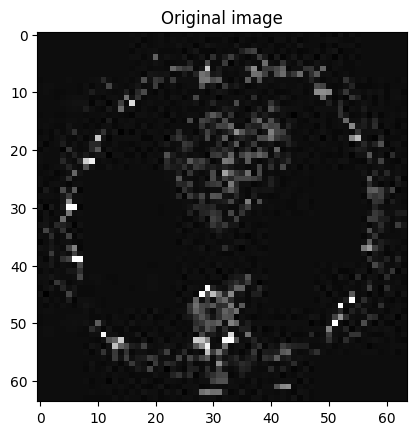

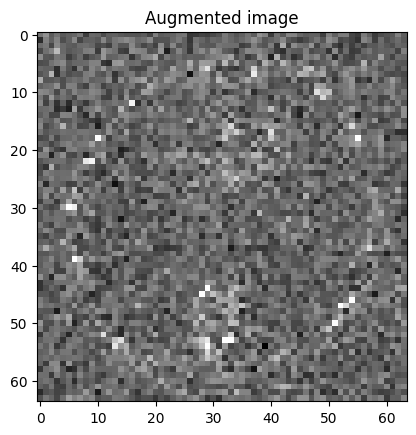

In [59]:
id = 10
plt.imshow(X_train[id], cmap='gray')
plt.title('Original image')
plt.show()

aug_example, _ = random_augment(np.expand_dims(X_train[id], 0), [Y_train[id]], n_images=1)
plt.imshow(aug_example.squeeze(), cmap='gray')
plt.title('Augmented image')
plt.show()

In [60]:
image_clf = Pipeline([('feature_extractor', FeatureExtractor(n_points=8, radius=3, method='uniform')),
                         ('classifier', SVC())])

# Create 500 augmented images
X_aug, Y_aug = random_augment(X_train[:data_size], Y_train[:data_size], n_images=500)
# Append the augmented images to the limited dataset
X_aug = np.append(X_train[:data_size], X_aug, axis=0)
Y_aug = np.append(Y_train[:data_size], Y_aug, axis=0)

# Train the model on augmented data
image_clf.fit(X_aug, Y_aug)
predictions = image_clf.predict(X_val)

# Predict on test for later
predictions_augmented = image_clf.predict(X_test)

# Validation results
print(f'Accuracy: {accuracy_score(predictions, Y_val):.3f}')
print(classification_report(Y_val, predictions, labels=[0, 1, 2, 3, 4, 5]))

# Create confusion matrix
conf = confusion_matrix(Y_val, predictions)
with pd.option_context('display.max_columns', 10):
    print(pd.DataFrame(conf, index=true_labels,
                       columns=pred_labels))

/Users/hpham/miniconda3/lib/python3.11/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Accuracy: 0.782
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       232
           1       0.92      1.00      0.96       220
           2       0.98      0.93      0.96       223
           3       0.58      0.99      0.73       218
           4       0.92      0.94      0.93       217
           5       0.67      0.87      0.76       217

    accuracy                           0.78      1327
   macro avg       0.68      0.79      0.72      1327
weighted avg       0.67      0.78      0.72      1327

        Pred 0  Pred 1  Pred 2  Pred 3  Pred 4  Pred 5
True 0       0       0       0     143       0      89
True 1       0     220       0       0       0       0
True 2       0       1     208       0      14       0
True 3       0       0       0     216       0       2
True 4       0       6       4       0     205       2
True 5       0      12       0      12       4     189


/Users/hpham/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/hpham/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/hpham/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

There was a good improvement for the training set with augmented images. The classification report and confusion matrix show that the performance with ChestCT images was improved.

# 5. Final results

Let's finally try to augment the full dataset to see if we can improve the results further.

In [61]:
image_clf = Pipeline([('feature_extractor', FeatureExtractor(n_points=8, radius=3, method='uniform')),
                         ('classifier', SVC())])

# Create 2500 augmented images
Xf_aug, Yf_aug = random_augment(X_train, Y_train, n_images=2500)
# Append the augmented images to the limited dataset
Xf_aug = np.append(X_train, Xf_aug, axis=0)
Yf_aug = np.append(Y_train, Yf_aug, axis=0)

# Train the model on augmented data
image_clf.fit(Xf_aug, Yf_aug)
predictions = image_clf.predict(X_val)

# Predict on test for later
predictions_full_augmented = image_clf.predict(X_test)

# Validation results
print(f'Accuracy: {accuracy_score(predictions, Y_val):.3f}')
print(classification_report(Y_val, predictions, labels=[0, 1, 2, 3, 4, 5]))

# Create confusion matrix
conf = confusion_matrix(Y_val, predictions)
with pd.option_context('display.max_columns', 10):
    print(pd.DataFrame(conf, index=true_labels,
                       columns=pred_labels))

/Users/hpham/miniconda3/lib/python3.11/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Accuracy: 0.943
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       232
           1       1.00      1.00      1.00       220
           2       0.96      0.98      0.97       223
           3       0.91      0.96      0.93       218
           4       0.98      0.95      0.96       217
           5       0.95      0.85      0.90       217

    accuracy                           0.94      1327
   macro avg       0.95      0.94      0.94      1327
weighted avg       0.94      0.94      0.94      1327

        Pred 0  Pred 1  Pred 2  Pred 3  Pred 4  Pred 5
True 0     213       0       0      11       0       8
True 1       0     220       0       0       0       0
True 2       0       0     219       0       4       0
True 3       9       0       0     209       0       0
True 4       0       1       9       0     206       1
True 5      22       0       0      10       0     185


It seems we achieved roughly the same accuracy as without augmentations. To make sure that we did not overfit to the training/validation sets, we can compare all of the results on the untouched **test set**.

In [62]:
print('Full dataset:')
print(f'Accuracy: {accuracy_score(predictions_full, Y_test):.3f}')
print(classification_report(Y_test, predictions_full, labels=[0, 1, 2, 3, 4, 5]))
print('Confusion matrix: \n', 
      pd.DataFrame(confusion_matrix(Y_test, predictions_full), 
                   index=true_labels, columns=pred_labels))

print('\n____________\nLimited dataset:')
print(f'Accuracy: {accuracy_score(predictions_reduced, Y_test):.3f}')
print(classification_report(Y_test, predictions_reduced, labels=[0, 1, 2, 3, 4, 5]))
print('Confusion matrix: \n', 
      pd.DataFrame(confusion_matrix(Y_test, predictions_reduced), 
                   index=true_labels, columns=pred_labels))

print('\n____________\nAugmented dataset:')
print(f'Accuracy: {accuracy_score(predictions_augmented, Y_test):.3f}')
print(classification_report(Y_test, predictions_augmented, labels=[0, 1, 2, 3, 4, 5]))
print('Confusion matrix: \n', 
      pd.DataFrame(confusion_matrix(Y_test, predictions_augmented), 
                   index=true_labels, columns=pred_labels))

print('\n____________\nAugmented full dataset:')
print(f'Accuracy: {accuracy_score(predictions_full_augmented, Y_test):.3f}')
print(classification_report(Y_test, predictions_full_augmented, labels=[0, 1, 2, 3, 4, 5]))
print('Confusion matrix: \n', 
      pd.DataFrame(confusion_matrix(Y_test, predictions_full_augmented), 
                   index=true_labels, columns=pred_labels))

Full dataset:
Accuracy: 0.943
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       321
           1       0.98      1.00      0.99       350
           2       0.99      0.98      0.98       319
           3       0.92      0.94      0.93       314
           4       0.98      0.96      0.97       329
           5       0.95      0.86      0.90       347

    accuracy                           0.94      1980
   macro avg       0.94      0.94      0.94      1980
weighted avg       0.94      0.94      0.94      1980

Confusion matrix: 
         Pred 0  Pred 1  Pred 2  Pred 3  Pred 4  Pred 5
True 0     293       0       0      13       0      15
True 1       0     350       0       0       0       0
True 2       0       0     312       0       7       0
True 3      17       0       0     296       0       1
True 4       0       8       3       1     317       0
True 5      35       0       0      13       0     299

____________
Limited 

# Conclusion

Now that we have completed all experiments, we can make a couple of conclusions:

- LBP is a pretty good feature extractor for clearly different image types. However, the dataset was quite easy to classify.

- To train an accurate model, a large amount of training images should be used. This can be alleviated by augmenting the existing images. Augmentation allows creating more artificial images.

- You should now know how to create machine learning models for images. Furthermore, you can also work with limited amount of images if a huge dataset is not available. **This is often the case with medical data that is highly regulated and difficult to obtain.**

**Possible next steps:**

- Hyperparameter optimization could be used to control the LBP hyperparameters as well as the amount of augmented images used.

- What happens if there is too much augmented images?

